# <center> Churn prediction model </center>

<center> Artificial Intelligence for communication and marketing </center>
<center> Chiara Barbieri, 517096 </center>

# Context

The chief of a e-commerce platform has raised concerns about a growing rate of customer churn, negatively effecting the revenue and future revenues of the company.

To reduce this trend, a churn prediction model, namely a model capable of predicting whether a certain customer is at high risk of churn, has to be created and employed. This model will allow to boost loyalty and profitability by the use of aimed retention strategies, such as personalized strategies.


## Importing the important libraries

In [1]:
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install hyperopt

Note: you may need to restart the kernel to use updated packages.


In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dropping the warning
import warnings
warnings.filterwarnings("ignore")

# For the preprocessing
from sklearn.preprocessing import LabelEncoder

# For the data splitting and balancing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

# For the model
import xgboost as xgb
from hyperopt import hp, STATUS_OK, Trials, fmin, tpe
from hyperopt.pyll.stochastic import sample

# For the evaluation
from sklearn.metrics import roc_curve, accuracy_score, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


# Importing the data

In [6]:
# Load the dataset
# Ensure you have the 'openpyxl' package installed to read Excel files
df_raw = pd.read_excel('data.xlsx')
df_raw.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001.0,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002.0,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003.0,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004.0,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005.0,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


The dataset has trasactional data and customer behavioural data.

The attributes reported by the dataset are the following:
- **Customer ID**: unique identifier of the customer
- **Churn**: whether the customer has churned
- **Tenure**: amount of time the customer has been loyal to the company
- **PreferredLogiDevice**: on which device the customer makes the purchase
- **CityTier**: level of urbanization of the city in which the purchase has been made
- **WarehouseToHome**: distance between the warehouse and the customer's home
- **PreferredPaymentMode**: most used method of payment
- **Gender**: female or male
- **HourSpendOnApp**: hours spent looking for items in the app
- **NumberOfDeviceRegistered**: from how many devices the customer has made the log-in
- **PreferredOrderCat**: preferred category of the customer during the last month
- **SatisfactionScore**: satisfaction in the products of the company
- **Marital status**: single, divorced, married or widow
- **Number of address**: count of the number of addresses indicated by the customer
- **Complain**: whether complaints were raised in the last month
- **OrderAmountHikeFromlastYear**: % increases in orders with respect to the previous year
- **CouponUsed**: total number of coupon used during the last month
- **OrderCount**: total number of orders placed during the previous month
- **DaySinceLastOrder**: days since the last order
- **CashbackAmount**: average cashback during the last month, so the amount of cash refound received by a customer after a purchase

# Familiarization with the dataset

Let's generally explore the main informations about the dataset

In [7]:
# Display basic information about the dataset
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5628 non-null   float64
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5628 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

In the dataset there are quite a few missing values

In [8]:
# Display the shape of the dataset
df_raw.shape

(5630, 20)

In the dataset we have:
- 5630 rows (customers)
- 20 columns (features)

## Understanding the missing values

In [9]:
# Display the amount of missing data
missing_data = df_raw.isnull().sum()
print("Missing data in each column:")
print(missing_data[missing_data > 0])

Missing data in each column:
CustomerID                       2
Tenure                         264
WarehouseToHome                251
Gender                           2
HourSpendOnApp                 255
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
dtype: int64


As we can see, there are many null values, which have to be investigated to understand whether we can just drop the row (if there are too many null values) or not. We can drop the row if there are more than 5 missing values (1/4 of the columns), to ensure validity when using the model.

In [10]:
# Check for missing values in each row and column
missing_rows = df_raw.isnull().sum(axis=1)

# Display how many rows have more than 1 missing value
more_than_5_missing = missing_rows[missing_rows > 5]
len_more_than_5_missing = len(more_than_5_missing)
print("Number of rows with more than 5 missing value:", len_more_than_5_missing)

Number of rows with more than 5 missing value: 0


From the code above, we get to know that there are no rows with more than 5 missing value, so we can't just drop the rows (or at least not all of them)

## Display the unique values of each column

In [11]:
# Display unique values in each column
for col in df_raw.columns:
    print(f"Column: {col} \n Values: {df_raw[col].unique()}")

Column: CustomerID 
 Values: [50001. 50002. 50003. ... 55628. 55629. 55630.]
Column: Churn 
 Values: [1 0]
Column: Tenure 
 Values: [ 4. nan  0. 13. 11.  9. 19. 20. 14.  8. 18.  5.  2. 30.  1. 23.  3. 29.
  6. 26. 28.  7. 24. 25. 10. 15. 22. 27. 16. 12. 21. 17. 50. 60. 31. 51.
 61.]
Column: PreferredLoginDevice 
 Values: ['Mobile Phone' 'Phone' 'Computer' 'N.A.']
Column: CityTier 
 Values: [3 1 2]
Column: WarehouseToHome 
 Values: [  6.   8.  30.  15.  12.  22.  11.   9.  31.  18.  13.  20.  29.  28.
  26.  14.  nan  10.  27.  17.  23.  33.  19.  35.  24.  16.  25.  32.
  34.   5.  21. 126.   7.  36. 127.]
Column: PreferredPaymentMode 
 Values: ['Debit Card' 'UPI' 'CC' 'Cash on Delivery' 'E wallet' 'COD' 'Credit Card']
Column: Gender 
 Values: ['Female' 'Male' nan]
Column: HourSpendOnApp 
 Values: [ 3.  2. nan  1.  0.  4.  5.]
Column: NumberOfDeviceRegistered 
 Values: [3 4 5 2 1 6]
Column: PreferedOrderCat 
 Values: ['Laptop & Accessory' 'Mobile' 'Mobile Phone' 'Others' 'Fashion' 'Gro

# Explorative data analysis and variable selection

In [12]:
df_clean = df_raw.copy()

## Dealing with null values

In [13]:
# Dealing with Customer ID

# Get an Index object of all rows where CustomerID is null
null_idx = df_clean[df_clean['CustomerID'].isnull()].index
print(null_idx)

# Drop rows where CustomerID is null
df_clean.drop(null_idx, inplace=True)

print(df_clean.shape)

Index([5457, 5524], dtype='int64')
(5628, 20)


In [14]:
# Dealing with Gender

# Get an Index object of all rows where Gender is null
null_idx = df_clean[df_clean['Gender'].isnull()].index
print(null_idx)

# Drop rows where Gender is null
df_clean.drop(null_idx, inplace=True)

print(df_clean.shape)

Index([2189, 2190], dtype='int64')
(5626, 20)


In [15]:
# Checking the type of the columns having missing values
null_cols = []
for col in df_clean.columns:
    if df_clean[col].isnull().any():
        null_cols.append(col)
        print(f"Column: {col}, Type: {df_clean[col].dtype}")

Column: Tenure, Type: float64
Column: WarehouseToHome, Type: float64
Column: HourSpendOnApp, Type: float64
Column: OrderAmountHikeFromlastYear, Type: float64
Column: CouponUsed, Type: float64
Column: OrderCount, Type: float64
Column: DaySinceLastOrder, Type: float64


All the columns with null values have the "float type", so we can use for all of them the median to replace the null values

In [16]:
# Dealing with null values in numerical columns filling with median
for col in null_cols:
    median_val = df_clean[col].median()
    df_clean[col].fillna(median_val, inplace=True)

In [17]:
if df_clean.isnull().sum().any():
    print("There are still missing values in the dataset.")
    df_clean.isnull().sum()
else:
    print("No missing values left in the dataset.")

No missing values left in the dataset.


## Understand the distribution of the attributes

Below there is the distribution of the **numerical features**

In [18]:
# Display basic statistics of the dataset
df_clean.describe()

,CustomerID,Churn,Tenure,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,SatisfactionScore,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
count,5626.000000,5626.000000,5626.000000,5626.000000,5626.000000,5626.000000,5626.000000,5626.000000,5626.000000,5626.000000,5626.000000,5626.000000,5626.000000,5626.000000,5626.000000
mean,52814.770885,0.168326,10.137931,1.654284,15.563100,2.934412,3.688589,3.067366,4.215073,0.284572,15.675791,1.717561,2.962851,4.459474,532.664083
std,1625.136986,0.374188,8.358702,0.915310,8.344048,0.705634,1.024188,1.380078,2.584114,0.451250,3.591512,1.857990,2.879976,3.571075,18849.532943
min,50001.000000,0.000000,0.000000,1.000000,5.000000,0.000000,1.000000,1.000000,1.000000,0.000000,11.000000,0.000000,1.000000,0.000000,0.000000
25%,51407.250000,0.000000,3.000000,1.000000,9.000000,2.000000,3.000000,2.000000,2.000000,0.000000,13.000000,1.000000,1.000000,2.000000,145.770000
50%,52815.500000,0.000000,9.000000,1.000000,14.000000,3.000000,4.000000,3.000000,3.000000,0.000000,15.000000,1.000000,2.000000,3.000000,163.330000
75%,54221.750000,0.000000,15.000000,3.000000,20.000000,3.000000,4.000000,4.000000,6.000000,1.000000,18.000000,2.000000,3.000000,7.000000,196.430000
max,55630.000000,1.000000,61.000000,3.000000,127.000000,5.000000,6.000000,5.000000,22.000000,1.000000,26.000000,16.000000,16.000000,46.000000,999999.000000


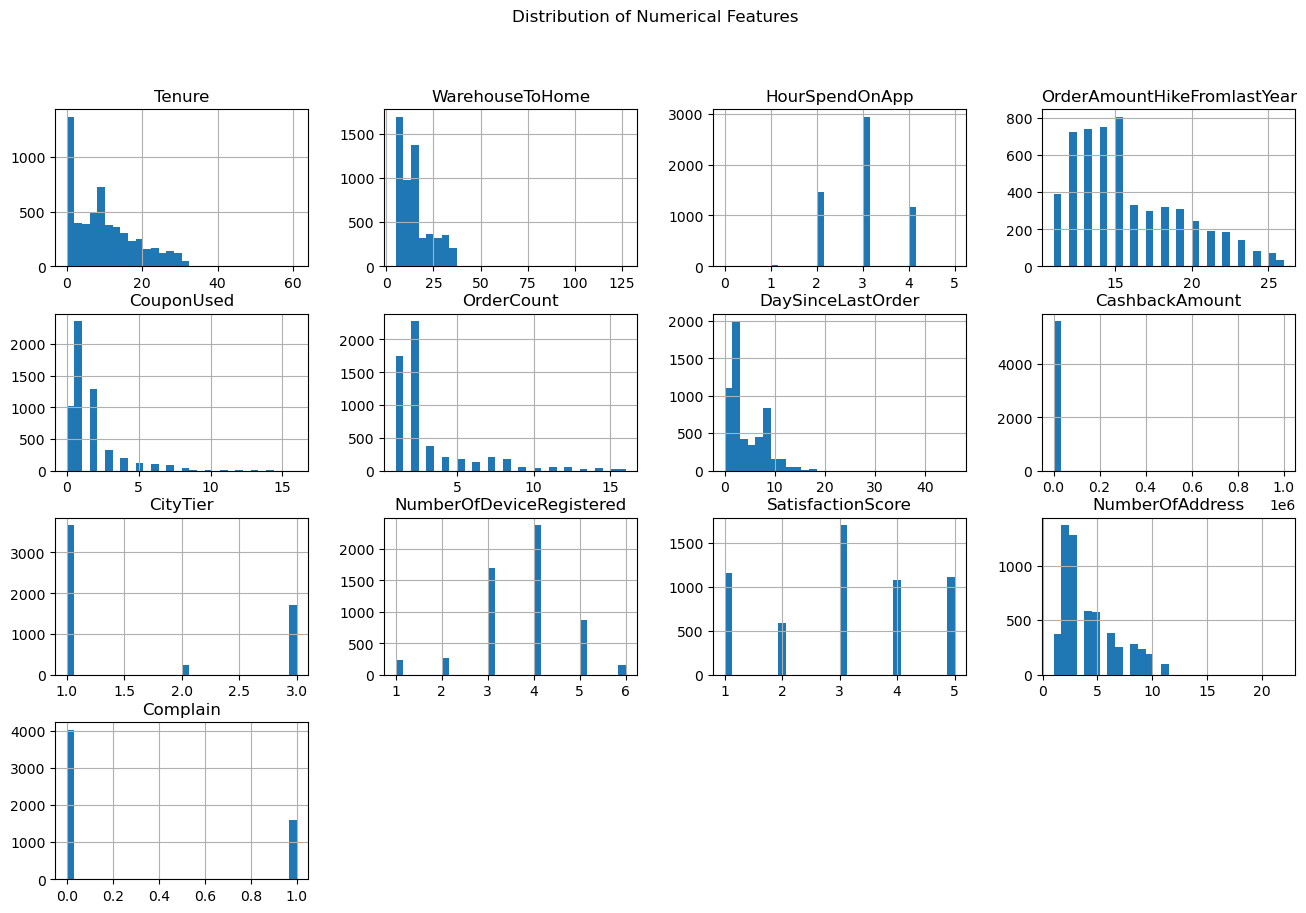

In [19]:
# Distribution plots for the numerical features
num_cols = ['Tenure', 'WarehouseToHome', 
            'HourSpendOnApp', 'OrderAmountHikeFromlastYear', 
            'CouponUsed', 'OrderCount', 
            'DaySinceLastOrder', 'CashbackAmount',
            'CityTier', 'NumberOfDeviceRegistered',
            'SatisfactionScore', 'NumberOfAddress', 
            'Complain']

df_clean[num_cols].hist(figsize=(16, 10), bins=30)
plt.suptitle('Distribution of Numerical Features')
plt.show()

From the distribution of the features, we get to know the following most important notions:
- More or less 1500 customers have been loyal to the company for just 1 year, and most of the customers that are being investigated have been loyal for less than 20 years
- Most consumers live close to the warehouse, so they get their orders quite fast
- On average the consumers spend 3 hours on the app
- On average the consumers have made 16% more orders with respect to the previous year
- Each consumer used on average 1-2 coupons out of the 3 orders made (on average)
- The average satisfaction score is 3, which is pretty neutral. This means that eventhough the company offers a good experience, consumers might churn, and go to a better company that offers better services, and not recommend the brand to other people
- More than 20% of the people complained


Below there is the distribution of the **categorical features**

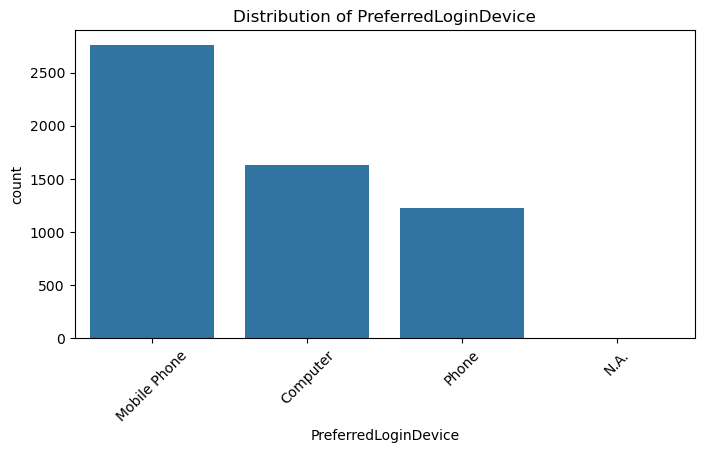

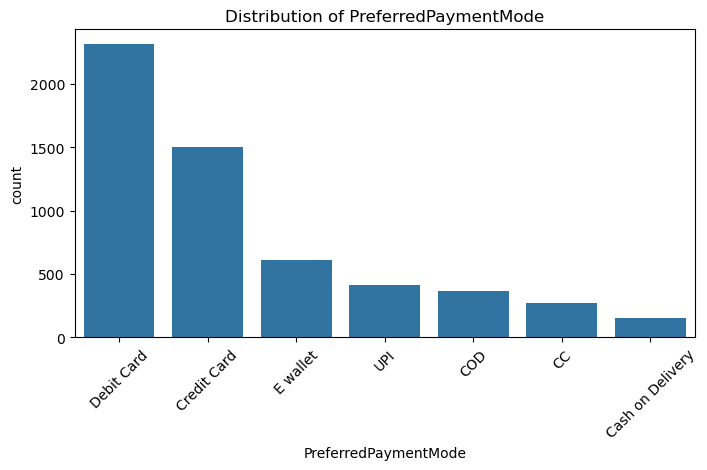

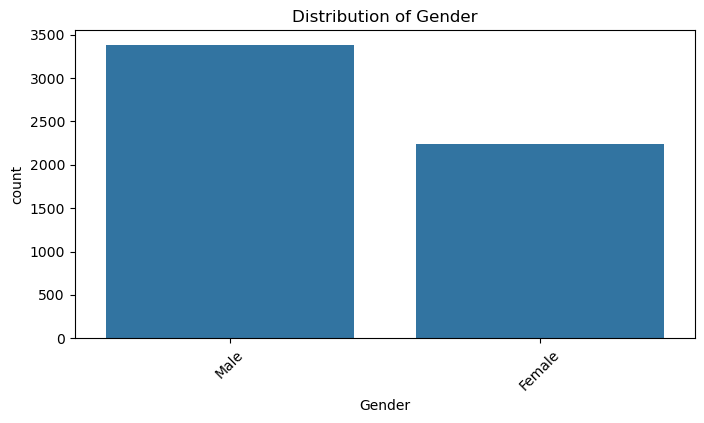

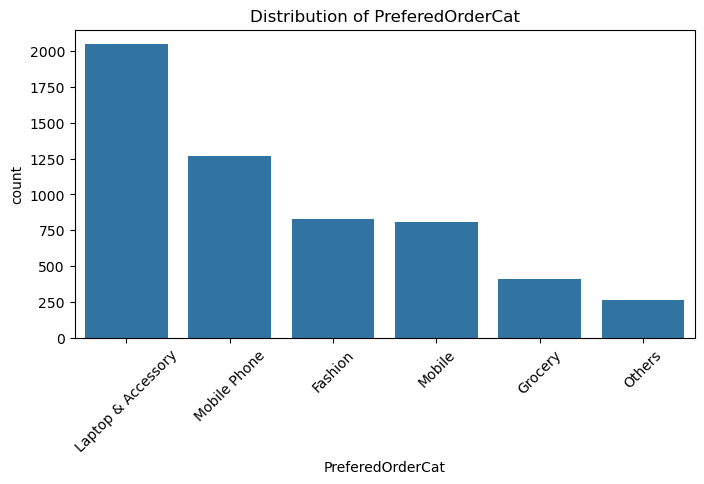

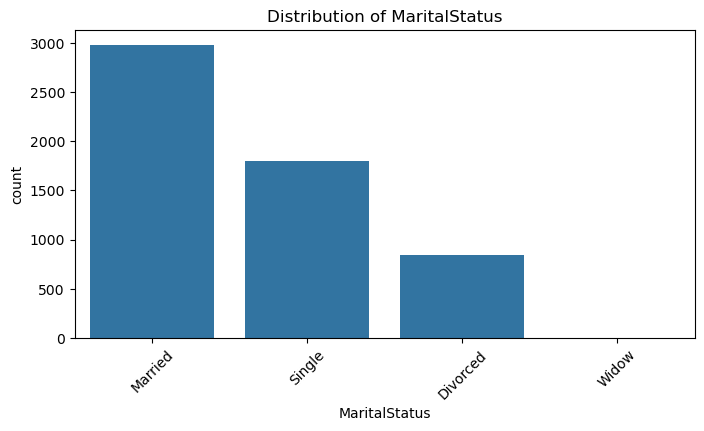

In [20]:
# Count plots for categorical features
cat_cols = ['PreferredLoginDevice', 'PreferredPaymentMode', 
            'Gender', 'PreferedOrderCat', 'MaritalStatus']

for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df_clean, x=col, order=df_clean[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()

Looking at the distributions, a few things were noticed and need to be adjusted

Starting with 'PreferredLoginDevice', which has two columns, "Mobile Phone" and "Phone", which mean the same thing.

In [21]:
# Renaming 'Mobile Phone' to 'Phone' in 'PreferredLoginDevice'
df_clean['PreferredLoginDevice'] = np.where(
    df_clean['PreferredLoginDevice'] == 'Mobile Phone', 'Phone',
    df_clean['PreferredLoginDevice']
)

Moreover, we have also noticed the presence of the value "N.A." (Not Available), a kind of NaN, so we replace the value with the most frequent value, that is "Phone"

In [22]:
# Renaming 'N.A.' to 'Phone' in 'PreferredLoginDevice'
df_clean['PreferredLoginDevice'] = np.where(
    df_clean['PreferredLoginDevice'] == 'N.A.', 'Phone',
    df_clean['PreferredLoginDevice']
)

Now that this feature is cleaned, we can check the distribution to ensure that everything was done correctly

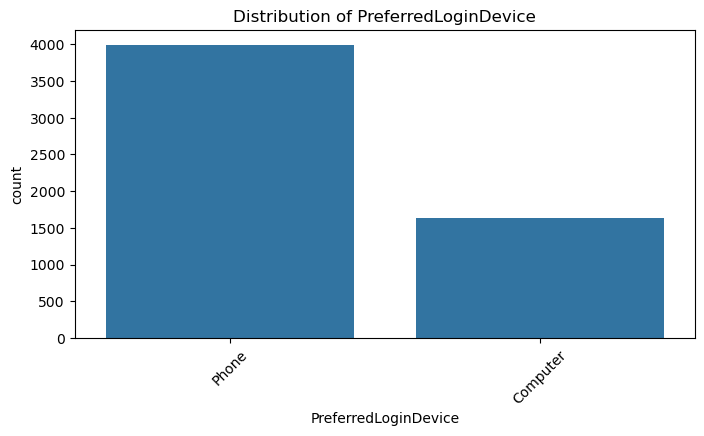

In [23]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df_clean, x='PreferredLoginDevice', order=df_clean['PreferredLoginDevice'].value_counts().index)
plt.title(f'Distribution of {'PreferredLoginDevice'}')
plt.xticks(rotation=45)
plt.show()

Continuing, we need to change the values of the preferred Payment method, that is "PreferredPaymentMode". Also in this case there a few values that mean the same thing, but are considered different.

In [24]:
# Renaming 'COD' to 'Cash on Delivery' in PreferredPaymentMode
df_clean['PreferredPaymentMode'] = np.where(
    df_clean['PreferredPaymentMode'] == 'COD', 'Cash on Delivery',
    df_clean['PreferredPaymentMode']
)

# Renaming 'CC' to 'Credit Card' in PreferredPaymentMode
df_clean['PreferredPaymentMode'] = np.where(
    df_clean['PreferredPaymentMode'] == 'CC', 'Credit Card',
    df_clean['PreferredPaymentMode']
)

Now that this feature is cleaned, we can check the distribution to ensure that everything was done correctly

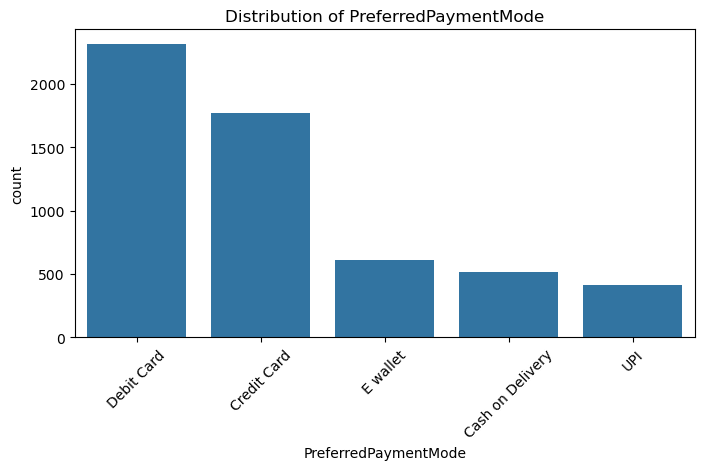

In [25]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df_clean, x='PreferredPaymentMode', order=df_clean['PreferredPaymentMode'].value_counts().index)
plt.title(f'Distribution of {'PreferredPaymentMode'}')
plt.xticks(rotation=45)
plt.show()

Now we clean the preferred order category, "PreferedOrderCat", changing the values "Mobile Phone" and "Mobile" to "Phone", done for consistency and to remove the repeated value

In [26]:
# Renaming 'Mobile Phone' to 'Phone' in PreferedOrderCat
df_clean['PreferedOrderCat'] = np.where(
    df_clean['PreferedOrderCat'] == 'Mobile Phone', 'Phone',
    df_clean['PreferedOrderCat']
)

# Renaming 'Mobile' to 'Phone' in PreferredOrderCat
df_clean['PreferedOrderCat'] = np.where(
    df_clean['PreferedOrderCat'] == 'Mobile', 'Phone',
    df_clean['PreferedOrderCat']
)

Now that this feature is cleaned, we can check the distribution to ensure that everything was done correctly

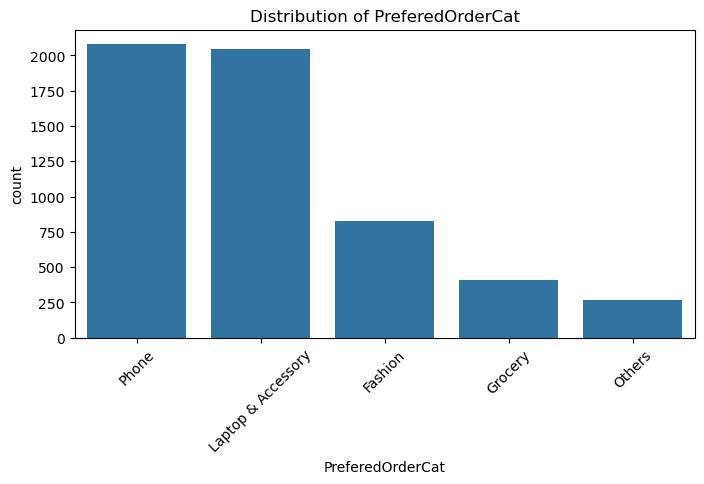

In [27]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df_clean, x='PreferedOrderCat', order=df_clean['PreferedOrderCat'].value_counts().index)
plt.title(f'Distribution of {'PreferedOrderCat'}')
plt.xticks(rotation=45)
plt.show()

Last but not least, we check if in 'MaritalStatus' we can remove the 'Widow' category, since it has very few values

In [28]:
df_clean['MaritalStatus'].value_counts()



MaritalStatus
Married     2980
Single      1795
Divorced     848
Widow          3
Name: count, dtype: int64

Even if there are only 3 values assigned to 'Widow', I will unite it with "Divorced" in one unique category "Separated". This is done to have one unique, more significant, category.

In [29]:
# Renaming "Divorced" to "Separated" in MaritalStatus
df_clean['MaritalStatus'] = np.where(
    df_clean['MaritalStatus'] == 'Divorced', 'Separated',
    df_clean['MaritalStatus']
)

# Renaming "Widow" to "Separated" in MaritalStatus
df_clean['MaritalStatus'] = np.where(
    df_clean['MaritalStatus'] == 'Widow', 'Separated',
    df_clean['MaritalStatus']
)

Now that this feature is cleaned, we can check the distribution to ensure that everything was done correctly

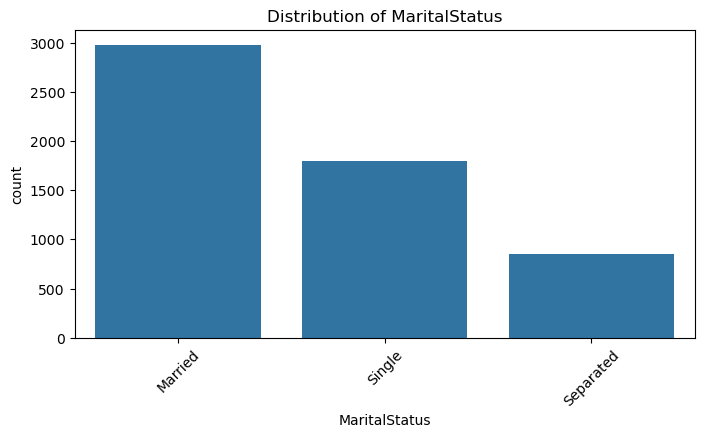

In [30]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df_clean, x='MaritalStatus', order=df_clean['MaritalStatus'].value_counts().index)
plt.title(f'Distribution of {'MaritalStatus'}')
plt.xticks(rotation=45)
plt.show()

## Checking the balance of the dataset

Considering that we will have to create a predictive model, it is always relevant to understand whether the number of instances of the classes (churn or not churn) are balanced or not in the dataset. Given the context, they should not be balanced.

In [31]:
# Display the percentages of churned and non-churned customers
percentages = df_clean["Churn"].value_counts(normalize=True) * 100
print(percentages.round(2))

Churn
0    83.17
1    16.83
Name: proportion, dtype: float64


In the dataset:
- % non-churned customers: 83.17%
- % churned customers: 16.83%

Text(0.5, 0, 'Churn')

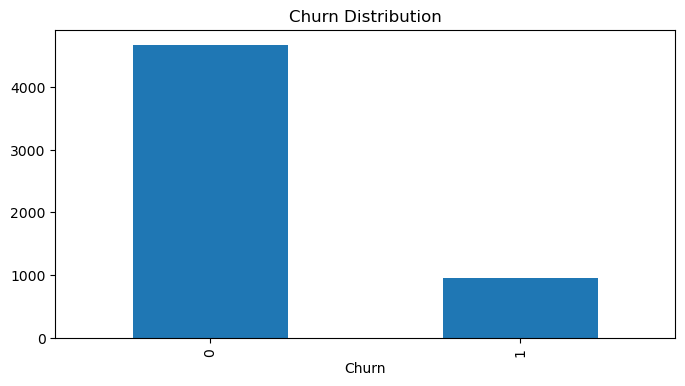

In [32]:
# Plot the distribution of churned and non-churned customers
df_clean["Churn"].value_counts().plot(kind='bar', figsize=(8, 4))
plt.title('Churn Distribution')
plt.xlabel('Churn') 

The dataset is imbalanced, with a higher number of non-churned customers compared to churned customers. This means that we will have to apply at least one technique of data balancing between undersampling, oversampling and creation of synthetic data samples 

For the purpose of this project synthetic data samples approach called SMOTE was chosen. I have chosen this method because it creates new data for the minority class without removing samples from the majority class. This will help the model generalize to unseen data, since it learns more samples.

These steps will be taken during the data splitting process, because it has to be applied only on the train set (we have to keep the original test set to validate the results of the model)

## Checking for duplicates in the dataset

In [33]:
df_clean.duplicated().sum()

np.int64(0)

There are no duplicate rows in the dataset

## Correlation matrix to understand the relationships between the variables

First, we need to encode the categorical variables into numbers, because otherwise they can't be incorporated into the correlation matrix. To do this, I use the *label Encoder* technique

In [34]:
le = LabelEncoder()
print(f"Categorical features: {cat_cols}")

for col in cat_cols:
    df_clean[col] = le.fit_transform(df_clean[col])

Categorical features: ['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'PreferedOrderCat', 'MaritalStatus']


Text(0.5, 1.0, 'Correlation Matrix')

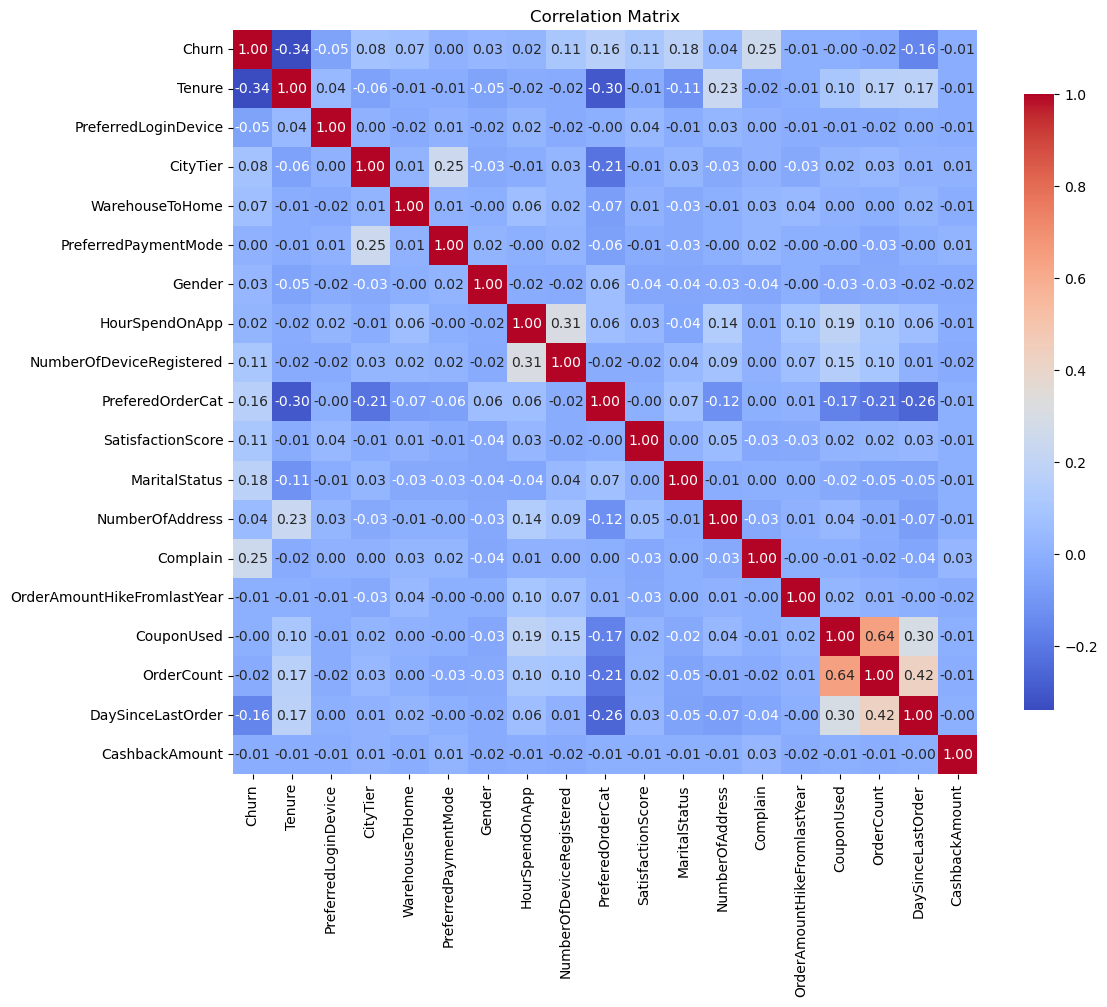

In [35]:
# Correlation matrix without considerig the customer ID (since not relevant for the churn prediction)
corr_matrix = df_clean.iloc[:, 1:].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix') 

From this correlation matrix we can state that most of the features are relevant since they have a correlation that goes towards 0 (meaning that the features are almost independent)

There are only a few combinations of features that differ from being close to 0.

In [36]:
# Features with positive correlation
for col in corr_matrix.columns:
    mask = (corr_matrix[col] > 0.2) & (corr_matrix[col] < 1)
    positive_corr = corr_matrix[mask][col].index.tolist()
    if len(positive_corr) > 0:
        print(f"Features with positive correlation to {col}: {positive_corr}")
    else:
        continue


Features with positive correlation to Churn: ['Complain']
Features with positive correlation to Tenure: ['NumberOfAddress']
Features with positive correlation to CityTier: ['PreferredPaymentMode']
Features with positive correlation to PreferredPaymentMode: ['CityTier']
Features with positive correlation to HourSpendOnApp: ['NumberOfDeviceRegistered']
Features with positive correlation to NumberOfDeviceRegistered: ['HourSpendOnApp']
Features with positive correlation to NumberOfAddress: ['Tenure']
Features with positive correlation to Complain: ['Churn']
Features with positive correlation to CouponUsed: ['OrderCount', 'DaySinceLastOrder']
Features with positive correlation to OrderCount: ['CouponUsed', 'DaySinceLastOrder']
Features with positive correlation to DaySinceLastOrder: ['CouponUsed', 'OrderCount']


From the positive correlations we get the following most relevant results:
- The churn is directly propotional to the complaints, so if the number of complaints is higher, also the number of churned customers is higher. Therefore, the disatisfaction with the service is most likely the main reason of churn.
- The hours spent on the app are directly proportional to the number of devices registered, so the more devices are registered, the more is likely for the customer to navigate the app, the more is likely that the customer will buy something.
- The number of coupons used, the number of orders done and the days that have passed since the last order are all directly proportional. This means that a high number of coupons used leads to a higher number of orders and a higher number of days that pass by between each order. Most likely, the customers might be waiting for the next coupon to arrive.

In [37]:
# Features with negative correlation
for col in corr_matrix.columns:
    mask = (corr_matrix[col] < -0.2) & (corr_matrix[col] > -1)
    negative_corr = corr_matrix[mask][col].index.tolist()
    if len(negative_corr) > 0:
        print(f"Features with positive correlation to {col}: {negative_corr}")
    else:
        continue

Features with positive correlation to Churn: ['Tenure']
Features with positive correlation to Tenure: ['Churn', 'PreferedOrderCat']
Features with positive correlation to CityTier: ['PreferedOrderCat']
Features with positive correlation to PreferedOrderCat: ['Tenure', 'CityTier', 'OrderCount', 'DaySinceLastOrder']
Features with positive correlation to OrderCount: ['PreferedOrderCat']
Features with positive correlation to DaySinceLastOrder: ['PreferedOrderCat']


From the negative correlation, on the other hand, we get to know the following relevant results:
- The Churn is inversely proportional to the tenure, meaning that the more time the customer has been loyal to the company, the less likely he/she will churn
- The tenure is also negatively correlated to the preferred order category, so it means that the preferred category is able to influence the loyalty of the customer. The preferred order category is also inversily proportional to the number of orders and the days since the last order. This means that these last two features, as for the tenure, are highly influenced by the category chosen by the customer. This makes sense because the preferred category with value is 0 is the 'Phone' and that with value 1 is 'Laptop&Accessories', which are both expensive and not changed frequently, so it makes sense that they are inversily proportional to the tenure, number of orders and the amount of days since the last order. If the value is 3 ('Groceries'), surely the purchases would be made more often, consequentially making the customer seem more loyal to the company.

## Repurchase curve

We want to define the repurchase curve, because it shows the optimal frequency of repurchase, so the optimal amount of days within which a customer has to make a repurchase before he/she is at risk of churning. This curve is defined by the repeater customers. 

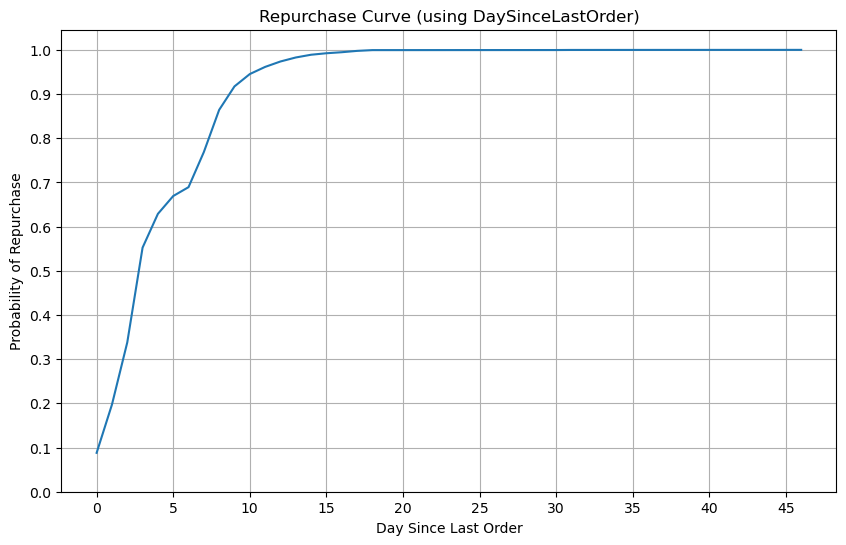

In [38]:
# Extract the data from the 'DaySinceLastOrder' column
days_since_last = df_clean['DaySinceLastOrder']

# Build the distribution of the probability of repurchase
cdf = days_since_last.value_counts().sort_index().cumsum() / len(days_since_last)
# We sort the days and calculate the probability of repurchase for each day

# Plot the distribution
plt.figure(figsize=(10,6))
plt.plot(cdf.index, cdf.values)

plt.xlabel('Day Since Last Order')
plt.xticks(np.arange(0, cdf.index.max() + 1, step=5))

plt.ylabel('Probability of Repurchase')
plt.yticks(np.arange(0, 1.05, step=0.1))

plt.title('Repurchase Curve (using DaySinceLastOrder)')
plt.grid(True)
plt.show()


As we can see from the graph, the 90% of the customers repurchase within 15 days

# Churn model development

## Data splitting

In [40]:
if 'CustomerID' in df_clean.columns:
    print("Dropping 'customerID' column as it is not relevant for the churn prediction.")
    df_clean.drop(columns=['CustomerID'], inplace=True)
else:
    print("'customerID' column is not present in the dataset.")

# Define the target variable and features
y = df_clean['Churn']

# Define the features (X) by dropping the target variable
X = df_clean.drop(columns=['Churn'])

Dropping 'customerID' column as it is not relevant for the churn prediction.


In [41]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, # data
    y, # labels
    test_size = 0.2,
    random_state=42,
    stratify=y
)

# Print the shapes of the resulting datasets
print(f"Shape of X_train: {X_train.shape}, Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}, Shape of y_test: {y_test.shape}")

Shape of X_train: (4500, 18), Shape of y_train: (4500,)
Shape of X_test: (1126, 18), Shape of y_test: (1126,)


Now we can plot the amount each labelin each set, done to visually check that label 1 and 0 are in both sets with the same proportions.

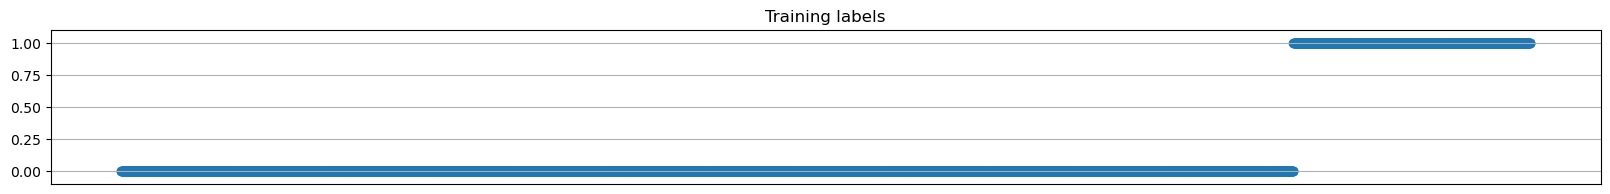

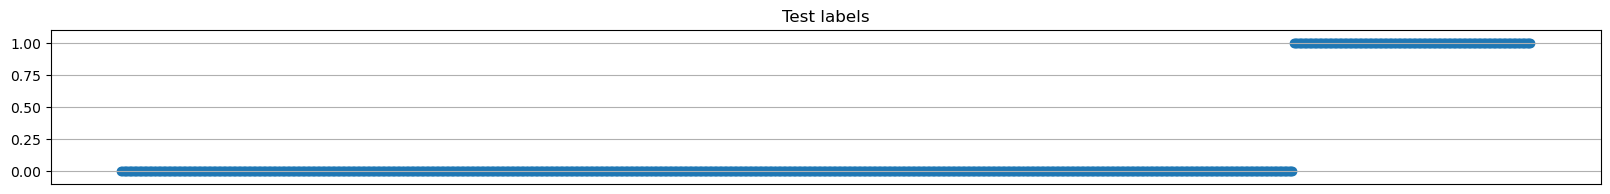

In [42]:
# Training labels subplot
plt.figure(figsize=(20, 2))
plt.scatter(np.arange(len(y_train)), np.sort(y_train, axis=0))
plt.title('Training labels')
plt.xticks([])          # Remove x-axis ticks
plt.grid(0.2)           # Add a grid with opacity 0.2 for reference
plt.ylim([-0.1, 1.1])   # Set the y-axis limits to [0.1, 1.1]

# Create a figure for the test labels subplot
plt.figure(figsize=(20, 2))
plt.scatter(np.arange(len(y_test)), np.sort(y_test, axis=0))
plt.title('Test labels')
plt.xticks([])          # Remove x-axis ticks
plt.grid(0.2)           # Add a grid with opacity 0.2 for reference
plt.ylim([-0.1, 1.1])   # Set the y-axis limits to [0.1, 1.1]

# Display the plots
plt.show()

As mentioned above, the technique used is SMOTE (Synthetic Minority Over-sampling)

In [45]:
# Applying the data balancing technique
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train) # Generate new data points for the minority class

# Display the shape of the balanced training set
print('Before SMOTE:', Counter(y_train))
print('After SMOTE:', Counter(y_train_balanced))

Before SMOTE: Counter({0: 3743, 1: 757})
After SMOTE: Counter({0: 3743, 1: 3743})


Visualization of the model being balanced:

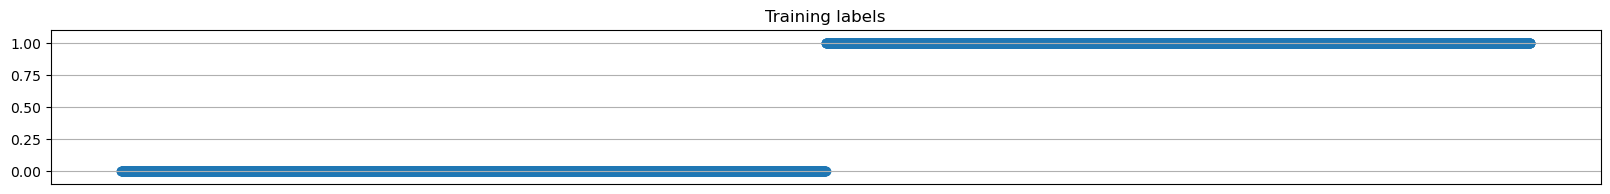

In [48]:
# Training labels subplot
plt.figure(figsize=(20, 2))
plt.scatter(np.arange(len(y_train_balanced)), np.sort(y_train_balanced, axis=0))
plt.title('Training labels')
plt.xticks([])          # Remove x-axis ticks
plt.grid(0.2)           # Add a grid with opacity 0.2 for reference
plt.ylim([-0.1, 1.1])   # Set the y-axis limits to [0.1, 1.1]

# Display the plots
plt.show()

## Model configuration and optimization

For the model optimization we will use a Bayesian Optimization to tune XGBoost (Gradient Boosting) model. The tuning includes hyperparameter optimization and cross validation. 

In [49]:
# Define the optimized data structure for XGBoost for faster training
train_dmatrix = xgb.DMatrix(data=X_train_balanced, label=y_train_balanced, enable_categorical=True)

# 10-fold cross-validation for robust model evaluation during tuning
N_FOLDS = 10

# Define the objective function for hyperparameter optimization
def objective(params, n_folds = N_FOLDS):
    params['objective'] = 'binary:logistic'

    # Perform cross-validation
    cv_results = xgb.cv(
        dtrain=train_dmatrix,
        params=params,
        nfold=n_folds,
        num_boost_round=10000,
        early_stopping_rounds=100, 
        metrics="auc",
        as_pandas=True,
        seed=42
    )

    # Print the metrics to optimize
    loss = 1 - cv_results["test-auc-mean"].iloc[-1] # Invert the AUC to a loss function to minimize
    n_estimators = cv_results["test-auc-mean"].idxmax() + 1
    return {'loss': loss, 'params': params, 'n_estimators': n_estimators, 'status': STATUS_OK}

# Define the hyperparameter space (possible hyperparameter values) for optimization
hyperparameter_space = {
    'n_jobs': -1,
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 0.8),
    'subsample': hp.uniform('subsample', 0.6, 0.8),
    'min_child_weight': hp.quniform('min_child_weight', 1, 7, 2),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'max_depth': hp.randint('max_depth', 1,16),
    'gamma': hp.uniform('gamma', 0.1,0.4),
    'max_delta_step': hp.randint('max_delta_step',0,10),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2))
}

# Initialize the trials object to store the results of each trial
bayes_trials = Trials()

# Number of tried combinations of hyperparameters
MAX_EVALS = 15

# Optimizer that finds the minimum of the objective function
best = fmin(fn = objective, space = hyperparameter_space, algo = tpe.suggest, max_evals = MAX_EVALS, trials = bayes_trials)

  0%|          | 0/15 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 15/15 [12:59<00:00, 51.99s/trial, best loss: 0.0018795166045775247]


In [53]:
# Best hyperparameters
print(f"Best hyperparameters:")
best

Best hyperparameters:


{'colsample_bytree': np.float64(0.6640111110973737),
 'gamma': np.float64(0.2419575575650229),
 'learning_rate': np.float64(0.025334719495959675),
 'max_delta_step': np.int64(9),
 'max_depth': np.int64(7),
 'min_child_weight': np.float64(2.0),
 'reg_alpha': np.float64(0.8754159357995059),
 'reg_lambda': np.float64(0.3566738677301543),
 'subsample': np.float64(0.773682247144195)}

## Training the best model

In [67]:
# Use the best hyperparameters to create and train the XGBoost model
xgb_best = xgb.XGBClassifier(**best, tree_method="hist", enable_categorical=True)
xgb_best.fit(X_train_balanced, y_train_balanced)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.6640111110973737), device=None,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=np.float64(0.2419575575650229), grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.025334719495959675), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=np.int64(9), max_depth=np.int64(7),
              max_leaves=None, min_child_weight=np.float64(2.0), missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

## Validate the results of the best model

Validate the model with the base scores:
- roc_auc score
- recall score
- precision score 
- accuracy score
- f1 score

In [75]:
# Define the evaluation metrics
list_scores = [roc_auc_score, recall_score, precision_score, accuracy_score, f1_score]

# Store the calculated scores
calc_scores = []

# Function to compute scores for the model
def compute_scores(model, x_test, y_test, scores):
    return [round(score(y_test, model.predict(x_test)), 2) for score in scores]

# Set the model and its name
models_list = [xgb_best]
model_names = ['Extreme Gradient Boosting for test set']

# Calculate the scores for the model
[calc_scores.append(compute_scores(model, X_test, y_test, list_scores)) for model in models_list] 

# Create a DataFrame to display the scores
score_names = ['roc_auc', 'recall', 'precision', 'accuracy', 'f1_score']
scores_df = pd.DataFrame(calc_scores, columns=score_names, index=model_names)

# Display the scores
scores_df

,roc_auc,recall,precision,accuracy,f1_score
Extreme Gradient Boosting for test set,0.86,0.77,0.76,0.92,0.77


Plot the roc curve

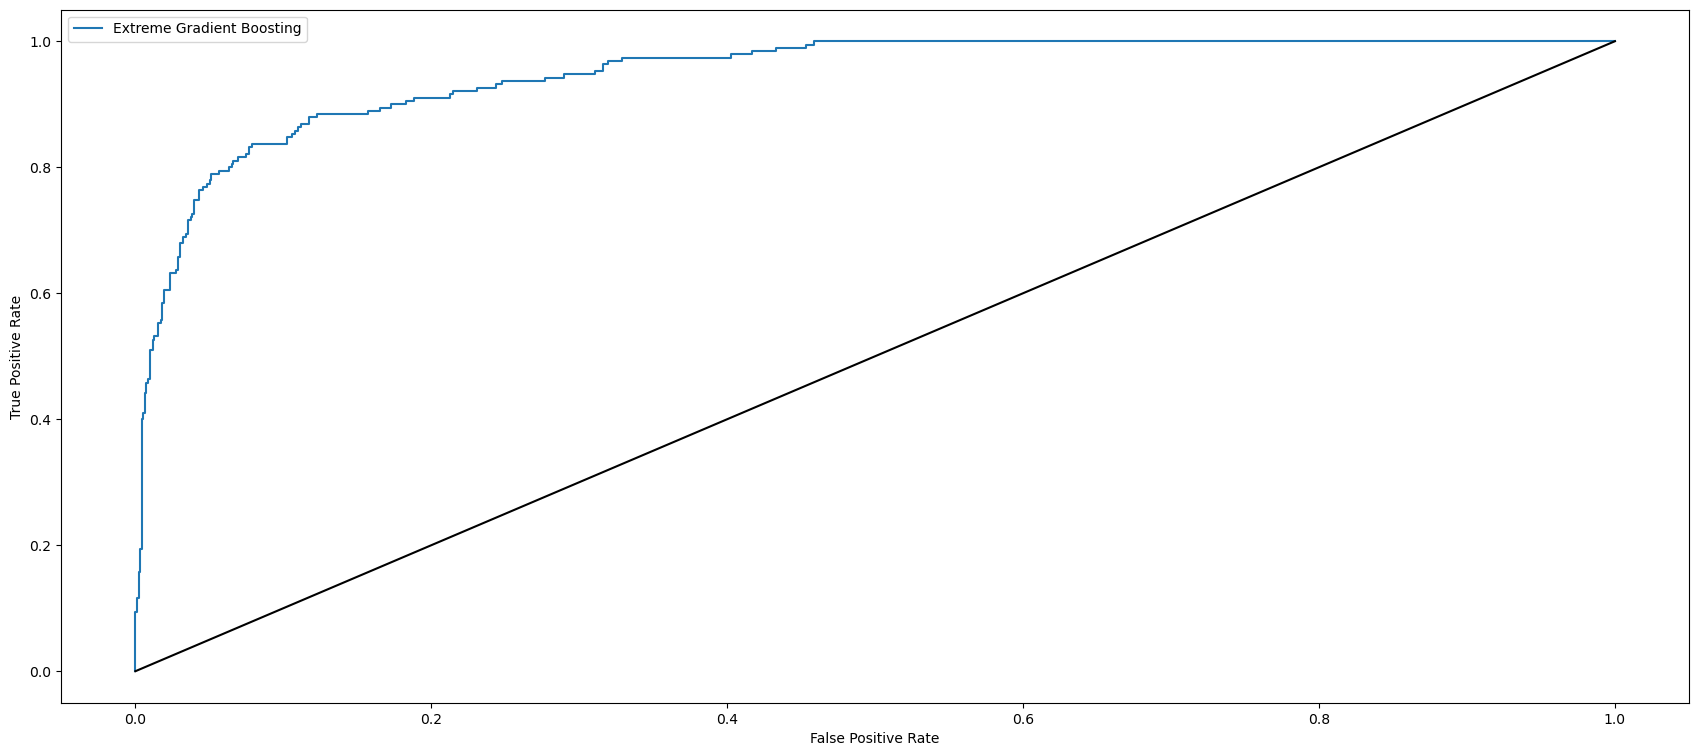

In [70]:
def add_roc_plot(model, test_x, test_y, legend_text):
    y_pred_prob = model.predict_proba(test_x)[:, 1]
    fpr, tpr, thresholds = roc_curve(test_y, y_pred_prob)
    plt.plot(fpr, tpr, label=legend_text)
    plt.legend()

models_list = [xgb_best]
model_names = ['Extreme Gradient Boosting']

plt.figure(figsize=(21, 9))
[add_roc_plot(model, X_test, y_test, legend_text) for model, legend_text in zip(models_list, model_names)]

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0, 1], [0, 1], "k-")
plt.show()

Check for overfitting

In [76]:
# Store the calculated scores
calc_scores_train = []

# Calculate the scores for the model
[calc_scores_train.append(compute_scores(model, X_train, y_train, list_scores)) for model in models_list] 

# Set the name 
model_names = ['Extreme Gradient Boosting for train set']

# Create a DataFrame to display the scores
score_names = ['roc_auc', 'recall', 'precision', 'accuracy', 'f1_score']
scores_df_train = pd.DataFrame(calc_scores_train, columns=score_names, index=model_names)

# Display the scores
scores_df_train

,roc_auc,recall,precision,accuracy,f1_score
Extreme Gradient Boosting for train set,0.92,0.87,0.83,0.95,0.85


The model is highly overfitting. The reasons for this are a few:
- The data has many outliers, most likely due to the data balancing of the train set
- Lack of regularization in the calculation of the loss, so the weights might have gotten to big
- No validation performance during training and no early stopping, so the model might have gone on for too long, starting to fit the outliers. This leads to the model learning too much the training data
- In the test set the data is not balanced, leading to the model not being able to assign correctly the minority class

Since the model is overfitting, we build a confusion matrix to understand which class is being misclassified

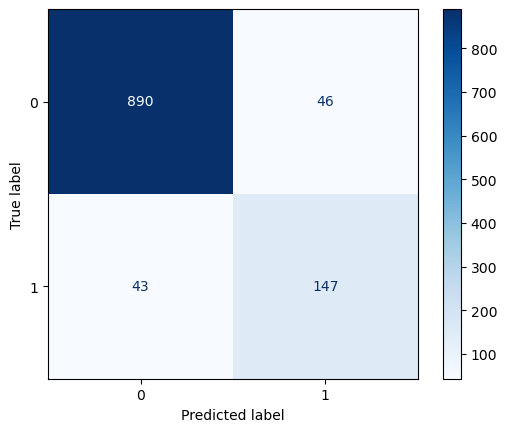

In [73]:
y_pred = xgb_best.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')

From the confusion matrix we get to understand that the two classes 0 (churn) and 1 (no churn) are being misclassified equally, since:
- Class 0 has 46 misclassified instances
- Class 1 has 43 misclassified instances

This means that the balancing was done correctly and we might need to work further on the model to add regularization and early stopping. This would be done to improve its ability of generalization.

For completeness we will finish the evaluation using a classification report

In [74]:
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       936
           1       0.76      0.77      0.77       190

    accuracy                           0.92      1126
   macro avg       0.86      0.86      0.86      1126
weighted avg       0.92      0.92      0.92      1126



From the classification report we see that the model is able to classify mostly correctly class 0 (the majority class) and has a worse performance on class 1 (the minority class). However this is expected, because given the imbalance of the dataset, it is more likely to classify correctly the majority class

# Model interpretation

Define churn classes:

In [ ]:
# Predicting the probability of churn for the test set
y_test_probs = xgb_best.predict_proba(X_test)[:, 1]

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'CustomerID': df_raw.loc[X_test.index, 'CustomerID'],  # Assuming CustomerID is in the original df_raw
    'Churn_Probability': y_test_probs
})

results_df['Churn_Risk_Class'] = np.where(
    results_df['Churn_Probability'] >= 0.7, 'High', # High risk of churn if the probability is 70% or more
    np.where(results_df['Churn_Probability'] >= 0.3, 'Medium', # Medium risk of churn if the probability is between 30% and 70%
    'Low') # Low risk of churn if the probability is less than 30%
)

results_df

,CustomerID,Churn_Probability,Churn_Risk_Class
3665,53666.0,0.533342,Medium
3435,53436.0,0.111551,Low
5624,55625.0,0.643026,Medium
2500,52501.0,0.092975,Low
1065,51066.0,0.085044,Low
...,...,...,...
2757,52758.0,0.125450,Low
5356,55357.0,0.499753,Medium
259,50260.0,0.287027,Low
3365,53366.0,0.251400,Low


Text(0.5, 1.0, 'Churn Risk Class Distribution')

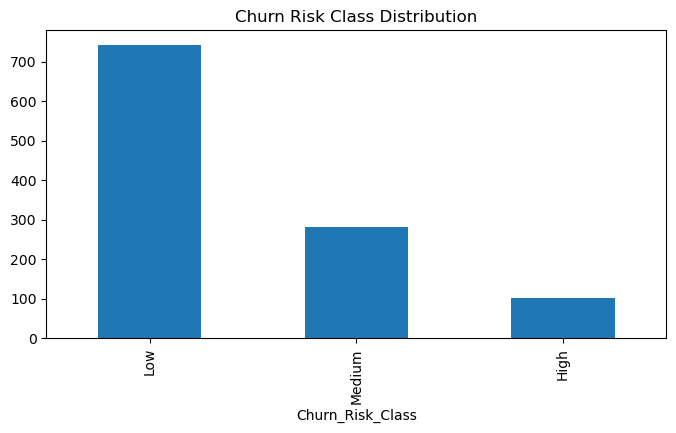

In [89]:
results_df['Churn_Risk_Class'].value_counts().plot(kind='bar', figsize=(8, 4))
plt.title('Churn Risk Class Distribution')

In [96]:
# Calculate the percentage of customers in each churn risk class
risk_class_percentages = results_df['Churn_Risk_Class'].value_counts(normalize=True)
risk_class_percentages *= 100
print(risk_class_percentages.round(1))

Churn_Risk_Class
Low       66.0
Medium    25.0
High       9.0
Name: proportion, dtype: float64


Now that we have defined the classes, we can apply different marketing techniques to satisfy all customers, but before we check which were the features that most influenced the result of the model in order to understand what are the factors that influence the most the churning of customers.

Check the features' importance:

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

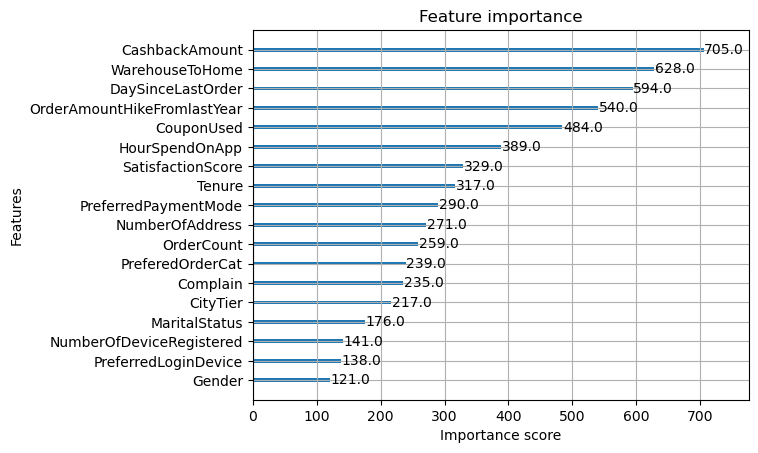

In [86]:
xgb.plot_importance(xgb_best)

## Business insight

From the above graphs and calculations we know that:
- 66% of customers are in the low-risk churn class
- 25% of customers are in the medium-risk churn class
- 9% of customers are in the high-risk churn class

This distribution shows that the majority of the customer base is stable (belong to the low-risk churn class), 34% of the customers are at risk of churn, so we should define proactive marketing actions to prevent the customers from leaving and protect the revenues.

Moreover, we get to know that the 4 factors that most influence the customer's churning are:
- The cashback amount, that if high is a great motivator for repurchase
- The distance between the warehouse and their house, since it reduced the waiting time, and so increases the satisfaction for the service
- The days since the last purchase, given that a higher number of days indicates a higher probability that the customer is churning (can also be seen in the repurchase curve)
- The % of more goods ordered during the previous year, as if more products are purchased, than this means that the customer is likely to have a higher tenure (be more loyal)

Finally from the correlation matrix we remember that:
- There is a high correlation between the number of complaints and the likelihood of churn
- Churn probability decreases as customer loyalty duration (tenure) increases. Long-term customers tend to be more loyal and non-churning
- The number of coupons used, the number of orders done and the days that have passed since the last order are all directly proportional
- Coupons are significant motivators for repeat purchases


Given these insights, we can think of quite a few data-driven strategies for the retention of the customer:
- **Improve customer service**: complaints should be handled faster with proactive follow-ups to improve in the category of the complaint. This would be done to work on the weaknesses of the company and satisfy current and future customers
- **Design targeted retention campaigns**: Do personalized offers based on the churned class. For the high and medium risk of churn classes there could be personalized incentives (for example exclusive cashback), while for the low risk of churn class strategies such as reminders to re-engage with the company should be enough. 
- **Optimize the coupon strategy and the cashback amount**: exploit coupons and cashback amounts for a steady purchasing, rather than creating long gaps where no purchases are made. This is done by testing small rewards for frequent low margin purchases and increasing the shopping frequency, and reduce the probability of churning.
- **Enhance delivery experience**: Find techniques, such as local delivery partnerships, to shorten delivery times for customers living far from the warehouses. Moreover, the company could add real-time tracking of the package and be transparent about the waiting times. This will enhance the satisfaction of the service.
- **Strengthen loyalty programs**: Rewards proportional to the tenure and to the purchasing history should be given to incentivize loyalty to the company

If these strategies are followed the customers will be more satisfied, reducing the probability of churn and they might even promote the company to other customers.